In [1]:
import cv2
import matplotlib.pyplot as plt
import glob
from google.colab import drive

## 1. Mount google drive & name it /mydrive/

In [2]:
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive

!ls /mydrive

Mounted at /content/gdrive
custom_object_detection


## 2. Clone and Build Darknet

In [3]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 14997, done.
remote: Total 14997 (delta 0), reused 0 (delta 0), pack-reused 14997
Receiving objects: 100% (14997/14997), 13.35 MiB | 24.33 MiB/s, done.
Resolving deltas: 100% (10193/10193), done.


In [4]:
!ls

darknet  gdrive  sample_data


In [5]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
           

## 3. Get & edit YOLOv3 Configuration file
- Make a copy & rename the original yolov3 config file
- Update Config file, classes & filters

In [6]:
# %cd darknet

# Make a copy & rename it to yolov3_custom.cfg
!cp cfg/yolov3.cfg cfg/yolov3_custom.cfg

[Errno 20] Not a directory: 'darknet'
/content/darknet


In [7]:
# Change classes number
classes = 1
filters = (classes + 5) * 3
max_batches = classes * 2000

if max_batches < 6000:
  max_batches = 6000

# Edit classes & filters
!sed -i 's/batch=1/batch=64/' cfg/yolov3_custom.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_custom.cfg
!sed -i 's/max_batches = 500200/max_batches = $max_batches/' cfg/yolov3_custom.cfg
!sed -i '610 s@classes=80@classes=$classes@' cfg/yolov3_custom.cfg
!sed -i '696 s@classes=80@classes=$classes@' cfg/yolov3_custom.cfg
!sed -i '783 s@classes=80@classes=$classes@' cfg/yolov3_custom.cfg
!sed -i '603 s@filters=255@filters=$filters@' cfg/yolov3_custom.cfg
!sed -i '689 s@filters=255@filters=$filters@' cfg/yolov3_custom.cfg
!sed -i '776 s@filters=255@filters=$filters@' cfg/yolov3_custom.cfg

## 4. Extract and prepare dataset for training process
- Create a new directory in darknet/data/ directory & extract dataset to the new directory
- Create classes.names & training.data
- Create training.txt file


In [10]:
!mkdir data/obj
!unzip /mydrive/custom_object_detection/Dataset.zip -d data/obj

mkdir: cannot create directory ‘data/obj’: File exists
Archive:  /mydrive/custom_object_detection/Dataset.zip
  inflating: data/obj/9.txt          
  inflating: data/obj/10.jpg         
  inflating: data/obj/10.txt         
  inflating: data/obj/11.jpg         
  inflating: data/obj/11.txt         
  inflating: data/obj/12.jpg         
  inflating: data/obj/12.txt         
  inflating: data/obj/1.jpg          
  inflating: data/obj/1.txt          
  inflating: data/obj/2.jpg          
  inflating: data/obj/2.txt          
  inflating: data/obj/3.jpg          
  inflating: data/obj/3.txt          
  inflating: data/obj/4.jpg          
  inflating: data/obj/4.txt          
  inflating: data/obj/5.jpg          
  inflating: data/obj/5.txt          
  inflating: data/obj/6.jpg          
  inflating: data/obj/6.txt          
  inflating: data/obj/7.jpg          
  inflating: data/obj/7.txt          
  inflating: data/obj/8.jpg          
  inflating: data/obj/8.txt          
  inflating: dat

In [12]:
# Add your object names to this list
custom_objects = ['laptop']

objects = "\n".join(custom_objects)

!echo -e $objects > data/obj.names
!echo -e 'classes = $classes\ntrain = data/train.txt\nvalid = data/test.txt\nnames = data/obj.names\nbackup = /mydrive/custom_object_detection/' > data/obj.data

In [13]:
images_list = glob.glob("data/obj/*[jpg|png|jpeg]")
print(images_list)

# Create train.txt file
file = open("data/train.txt", "w") 
file.write("\n".join(images_list)) 
file.close() 

['data/obj/5.jpg', 'data/obj/2.jpg', 'data/obj/1.jpg', 'data/obj/9.jpg', 'data/obj/4.jpg', 'data/obj/7.jpg', 'data/obj/11.jpg', 'data/obj/3.jpg', 'data/obj/10.jpg', 'data/obj/6.jpg', 'data/obj/12.jpg', 'data/obj/8.jpg']


## 5. Download YOLOv3 Pretrained weight

In [14]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2021-05-07 08:16:40--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  42.3MB/s    in 4.1s    

2021-05-07 08:16:45 (38.0 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



## 6. Start Training!

In [15]:
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show

Streaming output truncated to the last 5000 lines.
 total_bbox = 62661, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.719406), count: 5, class_loss = 0.924211, iou_loss = 0.400814, total_loss = 1.325025 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000003, iou_loss = 0.000000, total_loss = 0.000003 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000001, iou_loss = 0.000000, total_loss = 0.000001 
 total_bbox = 62666, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.713104), count: 4, class_loss = 1.134595, iou_loss = 0.512579, total_loss = 1.647174 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000004, iou_loss = 0.000000, total_loss = 0.000004 
v3 (mse 

## 7. Test predict using trained weights

In [28]:
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /mydrive/custom_object_detection/yolov3_custom_last.weights -thresh 0.25

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5, 

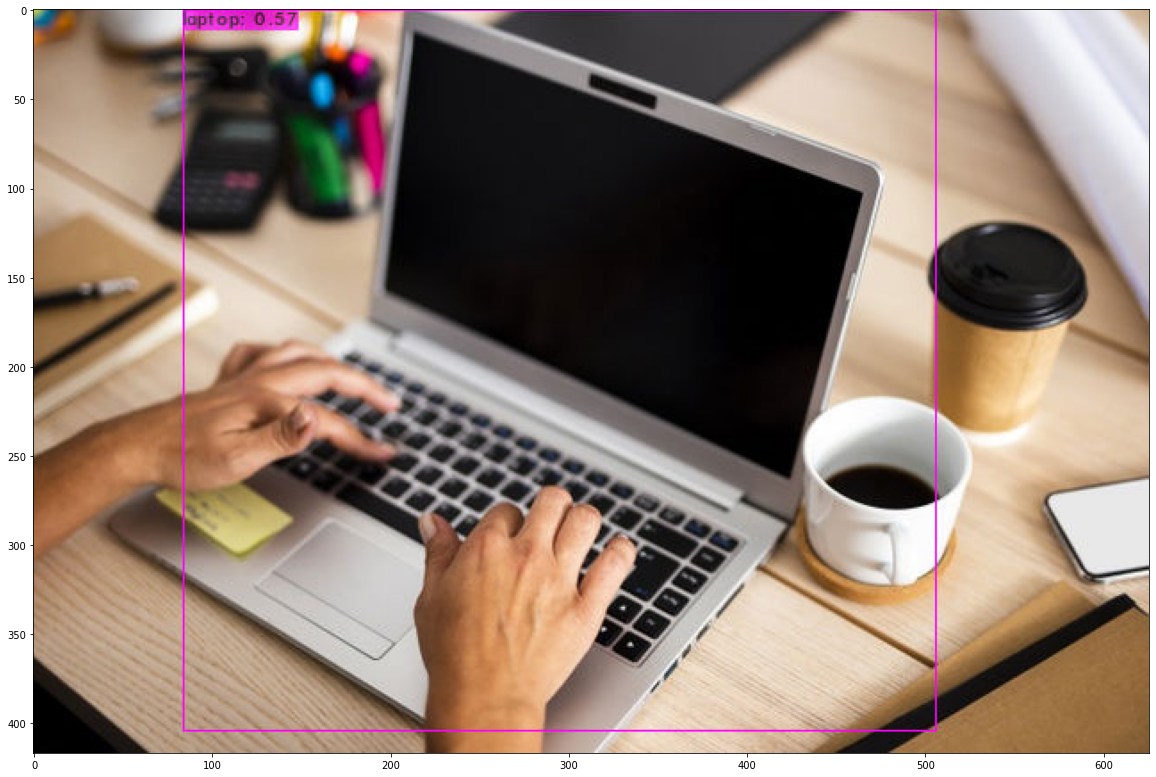

In [34]:
pred = cv2.imread('predictions.jpg')
pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(pred)